In [88]:
import torch
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$-\frac{d}{dx}(e^{\theta}\frac{du(x)}{dx}) = 1, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=1$$

with solution 
$$ u(x) = \frac{x - x^{2}}{2 e^{\theta}}$$

## The Problem consist in infering $ \alpha $

Text(0, 0.5, 'Observations')

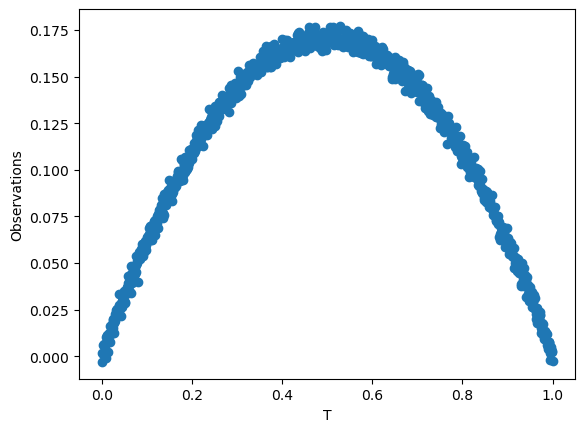

In [89]:
ns = 1
t= np.linspace(0,ns,1000)
mean, std = 0,np.sqrt(1e-5)
theta_t = np.zeros(1)

Exact = (t - t**2) / 2*np.exp(0.314)

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [90]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [91]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = -torch.exp(pr)*u_tt - 1
    return f

In [92]:
DNN.DE = DE

In [93]:
def sample_ic(size):
    return np.zeros(size)

def sample_bc(size):
    return np.ones(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [94]:
def data_pde(size,maxl,minp,maxp):

    t, param = samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

    X_u_train = torch.from_numpy(np.concatenate((t.reshape(-1,1),param),axis=1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_ic(size):
    ic = sample_ic(size)

    X_u_train = torch.from_numpy(ic.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_bc(size):
    bc = sample_bc(size)

    X_u_train = torch.from_numpy(bc.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

In [95]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,size)

    ic, bc, t, param = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

    ic, bc ,t, param = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.zeros_like(t)),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic + loss_u_bc

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [96]:
# Number of observations
epochs = 8000
nobs = 10
lr = 0.01

min_param , max_param = -1, 1

space = 1

layers = [2] + 1*[15] + [1]

In [97]:
model = DNN(layers)

In [98]:
loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [99]:
train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

# model.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/LA_toymodel_small_k.pt"))
# model.eval()

Starting Training
Iter 0, Loss: 9.16073e-01, Loss_ic: 7.90252e-02, Loss_f: 8.24647e-01
Iter 0, Loss: 8.50160e-01, Loss_ic: 4.49481e-02, Loss_f: 7.77621e-01
Iter 10, Loss: 5.87183e-01, Loss_ic: 8.17358e-03, Loss_f: 5.09684e-01
Iter 10, Loss: 5.56884e-01, Loss_ic: 9.24441e-03, Loss_f: 4.91675e-01
Iter 20, Loss: 5.17217e-01, Loss_ic: 1.25778e-02, Loss_f: 4.91560e-01
Iter 20, Loss: 5.00506e-01, Loss_ic: 9.09097e-03, Loss_f: 4.75533e-01
Iter 30, Loss: 3.80534e-01, Loss_ic: 4.99476e-03, Loss_f: 3.72800e-01
Iter 30, Loss: 3.73940e-01, Loss_ic: 6.26135e-03, Loss_f: 3.66994e-01
Iter 40, Loss: 1.79641e-01, Loss_ic: 1.05535e-02, Loss_f: 1.65150e-01
Iter 40, Loss: 1.78295e-01, Loss_ic: 1.19159e-02, Loss_f: 1.60812e-01
Iter 50, Loss: 1.67047e-01, Loss_ic: 3.53574e-03, Loss_f: 1.61884e-01
Iter 50, Loss: 1.63706e-01, Loss_ic: 3.11213e-03, Loss_f: 1.58528e-01
Iter 60, Loss: 8.51492e-02, Loss_ic: 1.41201e-03, Loss_f: 8.15059e-02
Iter 60, Loss: 8.10947e-02, Loss_ic: 1.32083e-03, Loss_f: 7.78282e-02
Iter

Iter 120, Loss: 5.28903e-02, Loss_ic: 2.42202e-04, Loss_f: 5.10121e-02
Iter 120, Loss: 5.23597e-02, Loss_ic: 3.03824e-04, Loss_f: 5.07631e-02
Iter 130, Loss: 5.58589e-02, Loss_ic: 2.19151e-04, Loss_f: 5.24186e-02
Iter 130, Loss: 5.52314e-02, Loss_ic: 6.71043e-05, Loss_f: 5.25251e-02
Iter 140, Loss: 5.17489e-02, Loss_ic: 2.93087e-04, Loss_f: 4.92474e-02
Iter 140, Loss: 5.06923e-02, Loss_ic: 1.80865e-04, Loss_f: 4.83930e-02
Iter 150, Loss: 1.56408e-02, Loss_ic: 3.07703e-04, Loss_f: 1.37557e-02
Iter 150, Loss: 1.49974e-02, Loss_ic: 3.04036e-04, Loss_f: 1.31022e-02
Iter 160, Loss: 7.12948e-03, Loss_ic: 4.26829e-04, Loss_f: 5.75864e-03
Iter 160, Loss: 7.22662e-03, Loss_ic: 3.60351e-04, Loss_f: 5.75085e-03
Iter 170, Loss: 3.90154e-02, Loss_ic: 3.01759e-05, Loss_f: 3.66265e-02
Iter 170, Loss: 3.82944e-02, Loss_ic: 6.16122e-05, Loss_f: 3.58893e-02
Iter 180, Loss: 2.39414e-02, Loss_ic: 1.30423e-04, Loss_f: 2.21031e-02
Iter 180, Loss: 2.27518e-02, Loss_ic: 4.66402e-05, Loss_f: 2.14578e-02
Iter 1

In [100]:
#torch.save(model.state_dict(),"../Projects-1/Physics _Informed_NN/Models/LA_toymodel_small_k.pt")

In [101]:
def test_set(max_space,obs,param,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = (t - t**2) / (2*np.exp(param))

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

In [102]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_0'))

data_pde_ = data_pde(nobs,space,min_param , max_param)

t,param = next(iter(data_pde_))

t, param = Variable(t[:,0].reshape(-1,1),requires_grad=True),Variable(t[:,1:],requires_grad=True)

##############################################

u = model(torch.cat([t, param], dim=1))

u_t = torch.autograd.grad(
    u, t, 
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True
)[0]

u_tt = torch.autograd.grad(
    u_t, t, 
    grad_outputs=torch.ones_like(u_t),
    retain_graph=True,
    create_graph=True
)[0]

f_pred = -torch.exp(param)*u_tt - 1
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1 = torch.cat((forw_activation['layers.activation_0'],torch.ones_like(ddf_ff_1)),1)

print(ddf_ff_1)

tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000]])


In [103]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_0'))

ic_pred = model(torch.cat([torch.zeros_like(t), param],dim=1))

h1.remove()

loss_u_ic = loss(ic_pred,torch.zeros_like(ic_pred))

df_f_2 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_2 = grad(df_f_2, ic_pred, torch.ones_like(df_f_1))[0]

df_theta_2 = torch.cat((forw_activation['layers.activation_0'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_2)

tensor([[ 0.1729,  0.7510, -0.4605,  0.8589, -0.9217,  0.9724, -0.7069, -0.4578,
          0.6016,  0.9446,  0.8227, -0.7952, -0.0159, -0.2187,  0.8847,  1.0000],
        [ 0.2861,  0.8547,  0.1029,  0.8636, -0.6096,  0.9064,  0.1982, -0.7703,
         -0.2334,  0.6527,  0.8727, -0.8747, -0.0161, -0.8352,  0.6593,  1.0000],
        [ 0.1259,  0.6940, -0.6288,  0.8570, -0.9610,  0.9832, -0.8656, -0.2758,
          0.7896,  0.9748,  0.7981, -0.7522, -0.0159,  0.1706,  0.9275,  1.0000],
        [ 0.2326,  0.8111, -0.1833,  0.8614, -0.8132,  0.9476, -0.3081, -0.6459,
          0.2073,  0.8509,  0.8506, -0.8409, -0.0160, -0.6250,  0.7941,  1.0000],
        [ 0.1034,  0.6634, -0.6931,  0.8561, -0.9720,  0.9867, -0.9089, -0.1809,
          0.8477,  0.9827,  0.7853, -0.7293, -0.0159,  0.3446,  0.9420,  1.0000],
        [ 0.1655,  0.7426, -0.4900,  0.8586, -0.9298,  0.9744, -0.7396, -0.4310,
          0.6380,  0.9510,  0.8190, -0.7889, -0.0159, -0.1586,  0.8928,  1.0000],
        [ 0.1201,  0.6

In [104]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_0'))

bc_pred = model(torch.cat([torch.ones_like(t)*2, param],dim=1))

h1.remove()

loss_u_bc = loss(bc_pred,torch.zeros_like(bc_pred))

df_f_3 = grad(loss_u_bc, bc_pred, create_graph=True)[0]

ddf_ff_3 = grad(df_f_3, bc_pred, torch.ones_like(df_f_1))[0]

df_theta_3 = torch.cat((forw_activation['layers.activation_0'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_3)

tensor([[ 0.9803,  0.6623,  0.8392, -0.3767,  0.2437,  0.2074, -0.6778,  0.7973,
          0.9509,  0.9996,  0.8010, -0.7309,  0.0368, -0.3447,  0.9997,  1.0000],
        [ 0.9844,  0.7987,  0.9488, -0.3611,  0.8146, -0.3941,  0.2513,  0.5114,
          0.7203,  0.9971,  0.8566, -0.8330,  0.0366, -0.8722,  0.9988,  1.0000],
        [ 0.9783,  0.5897,  0.7518, -0.3829, -0.1090,  0.4319, -0.8509,  0.8624,
          0.9765,  0.9998,  0.7737, -0.6769,  0.0368,  0.0352,  0.9998,  1.0000],
        [ 0.9825,  0.7406,  0.9106, -0.3686,  0.6122, -0.1151, -0.2567,  0.6736,
          0.8755,  0.9989,  0.8320, -0.7893,  0.0367, -0.7015,  0.9993,  1.0000],
        [ 0.9773,  0.5514,  0.6977, -0.3858, -0.2722,  0.5238, -0.8987,  0.8859,
          0.9835,  0.9999,  0.7597, -0.6484,  0.0369,  0.2186,  0.9998,  1.0000],
        [ 0.9800,  0.6515,  0.8276, -0.3777,  0.1898,  0.2451, -0.7132,  0.8091,
          0.9563,  0.9997,  0.7969, -0.7229,  0.0368, -0.2886,  0.9997,  1.0000],
        [ 0.9780,  0.5

In [105]:
wt,bias = model.layers[-1].weight, model.layers[-1].bias

param_MAP = torch.cat((wt,bias.reshape(1,1)),1) 

nparam = param_MAP.reshape(-1).shape

print(df_theta_1.shape,df_theta_2.shape,df_theta_3.shape,nparam)

torch.Size([10, 16]) torch.Size([10, 16]) torch.Size([10, 16]) torch.Size([16])


In [106]:
H = (nobs/2)*(torch.sum(df_theta_1*ddf_ff_1*df_theta_1,axis=0)+ torch.sum(df_theta_2*ddf_ff_2*df_theta_2,axis=0)+torch.sum(df_theta_3*ddf_ff_3*df_theta_3,axis=0))

print(H,H.shape)

from torch.distributions.multivariate_normal import _precision_to_scale_tril


Hfull = (nobs/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1, df_theta_1), ddf_ff_1),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2, df_theta_2), ddf_ff_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3, df_theta_3), ddf_ff_3),axis=0))


print(Hfull,Hfull.shape)

tensor([1.3565e+01, 1.5351e+01, 1.1003e+01, 1.3628e+01, 1.5718e+01, 1.8503e+01,
        1.4277e+01, 9.0864e+00, 1.7594e+01, 2.7858e+01, 1.9862e+01, 1.7720e+01,
        1.6706e-02, 5.8478e+00, 2.6762e+01, 3.0000e+01]) torch.Size([16])
tensor([[ 1.3565e+01,  1.1949e+01,  7.7758e+00,  1.4449e+00, -2.8021e+00,
          8.2493e+00, -9.3358e+00,  6.2203e+00,  1.3502e+01,  1.6852e+01,
          1.3938e+01, -1.2980e+01,  3.3096e-01, -4.9768e+00,  1.6737e+01,
          1.7203e+01],
        [ 1.1949e+01,  1.5351e+01,  2.1290e+00,  8.9100e+00, -9.7711e+00,
          1.4547e+01, -1.1890e+01,  6.4529e-01,  1.4587e+01,  2.0404e+01,
          1.7415e+01, -1.6483e+01,  1.0252e-01, -5.5491e+00,  1.9970e+01,
          2.1335e+01],
        [ 7.7758e+00,  2.1290e+00,  1.1003e+01, -7.6376e+00,  7.9206e+00,
         -4.0263e+00,  7.9559e-01,  7.5684e+00,  3.3363e+00,  3.4073e+00,
          2.6970e+00, -2.3767e+00,  3.9731e-01, -4.0887e+00,  3.6982e+00,
          3.2710e+00],
        [ 1.4449e+00,  8.9100e+

In [107]:
_sigma_noise=torch.tensor([1])
temperature=torch.tensor([1])

def sigma_noise():
    return _sigma_noise

def _H_factor():
    sigma2 = sigma_noise().square()
    return 1 / sigma2 / temperature

def prior_precision_diag(prior_precision,n_params):
    """Obtain the diagonal prior precision \\(p_0\\) constructed from either
    a scalar, layer-wise, or diagonal prior precision.

    Returns
    -------
    prior_precision_diag : torch.Tensor
    """
    if len(prior_precision) == 1:  # scalar
        return prior_precision * torch.ones(n_params, device=device)

    elif len(prior_precision) == n_params:  # diagonal
        return prior_precision

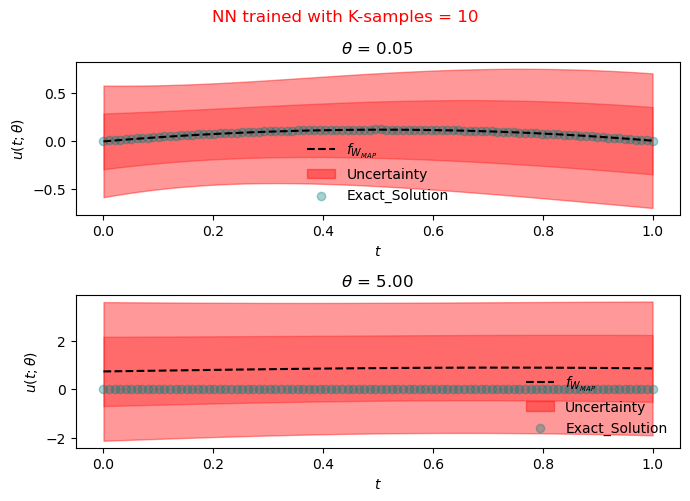

In [108]:
param_trained =  np.array([0.05,5])

prior_pre=torch.tensor([1])

prior_pre_diag_ = prior_precision_diag(prior_pre,nparam)

# Plotting
fig = plt.figure(figsize=(7,7))
plt.suptitle("NN trained with K-samples = 10",color = "red")

for n,pr in enumerate(param_trained):

    t, noise_sol_test = test_set(1,100,pr,mean,0)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))

    ######################################################################################

    forw_activation = {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_0'))

    f  = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation['layers.activation_0']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag_)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    #######################################################################################
    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)



    plt.subplot(3, 1, n + 1)

    plt.title(fr"$\theta$ = {pr:0.2f} ")
    plt.plot(t, f_mu, "--",color="black",label = r'$f_{W_{MAP}}$')
    plt.fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.3, color = "red")
    plt.fill_between(t, f_mu+2*f_sigma,f_mu-2*f_sigma,alpha=0.4, color = "red",label = "Uncertainty")
    plt.scatter(t,noise_sol_test, label = "Exact_Solution",color= "teal",alpha = 0.35)

    #plt.ylim(-4,5)

    plt.xlabel("$t$")
    plt.ylabel("$u(t;\\theta)$")
    plt.legend(frameon=False)
    plt.tight_layout()

plt.show()

In [109]:
nobs = 150
model2 = DNN(layers)

loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )

optimizer = torch.optim.Adam(model2.parameters(), lr = lr)
train(epochs, model2,loss,optimizer,nobs,space,min_param , max_param)


Starting Training
Iter 0, Loss: 1.11442e+00, Loss_ic: 1.57601e-02, Loss_f: 1.03035e+00
Iter 0, Loss: 1.02413e+00, Loss_ic: 8.96988e-03, Loss_f: 9.83546e-01
Iter 10, Loss: 7.33699e-01, Loss_ic: 1.61188e-02, Loss_f: 7.06448e-01
Iter 10, Loss: 7.06740e-01, Loss_ic: 1.21901e-02, Loss_f: 6.84785e-01
Iter 20, Loss: 4.96746e-01, Loss_ic: 5.50871e-03, Loss_f: 4.85779e-01
Iter 20, Loss: 4.69932e-01, Loss_ic: 4.52913e-03, Loss_f: 4.59202e-01
Iter 30, Loss: 2.71482e-01, Loss_ic: 1.55466e-04, Loss_f: 2.63525e-01
Iter 30, Loss: 2.61638e-01, Loss_ic: 3.19268e-04, Loss_f: 2.54673e-01
Iter 40, Loss: 2.01852e-01, Loss_ic: 6.20529e-03, Loss_f: 1.89590e-01
Iter 40, Loss: 1.95413e-01, Loss_ic: 6.11020e-03, Loss_f: 1.82948e-01
Iter 50, Loss: 1.67332e-01, Loss_ic: 3.79067e-03, Loss_f: 1.55978e-01
Iter 50, Loss: 1.61432e-01, Loss_ic: 3.23549e-03, Loss_f: 1.51135e-01
Iter 60, Loss: 8.75837e-02, Loss_ic: 1.13028e-04, Loss_f: 8.52222e-02
Iter 60, Loss: 8.47207e-02, Loss_ic: 2.44998e-04, Loss_f: 8.29044e-02
Iter

In [110]:
# a dict to store the activations
forw_activation2 = {}
def forw_getActivation2(name):
  # the hook signature
  def hook(model2, input, output):
    forw_activation2[name] = output.detach()
  return hook

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_0'))

data_pde_ = data_pde(nobs,space,min_param , max_param)

t,param = next(iter(data_pde_))

t, param = Variable(t[:,0].reshape(-1,1),requires_grad=True),Variable(t[:,1:],requires_grad=True)

##############################################

u = model2(torch.cat([t, param], dim=1))

u_t = torch.autograd.grad(
    u, t, 
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True
)[0]

u_tt = torch.autograd.grad(
    u_t, t, 
    grad_outputs=torch.ones_like(u_t),
    retain_graph=True,
    create_graph=True
)[0]

f_pred = -torch.exp(param)*u_tt - 1
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1_2 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1_2 = grad(df_f_1_2, f_pred, torch.ones_like(df_f_1_2))[0]

df_theta_1_2 = torch.cat((forw_activation2['layers.activation_0'],torch.ones_like(ddf_ff_1_2)),1)

print(df_theta_1_2)

tensor([[-0.4999,  0.6908,  0.8421,  ..., -0.6111, -0.4262,  1.0000],
        [-0.4894,  0.8302,  0.9523,  ..., -0.8992, -0.8412,  1.0000],
        [-0.7100,  0.8864,  0.9699,  ..., -0.7703, -0.8818,  1.0000],
        ...,
        [-0.5167,  0.7224,  0.8701,  ..., -0.6565, -0.5193,  1.0000],
        [-0.7426,  0.8764,  0.9623,  ..., -0.6338, -0.8397,  1.0000],
        [-0.7834,  0.8529,  0.9426,  ..., -0.2885, -0.7266,  1.0000]])


In [111]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_0'))

ic_pred = model2(torch.cat([torch.zeros_like(t), param],dim=1))

h1.remove()

loss_u_ic = loss(ic_pred,torch.zeros_like(ic_pred))

df_f_2_2 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_2_2 = grad(df_f_2_2, ic_pred, torch.ones_like(df_f_2_2))[0]

df_theta_2_2 = torch.cat((forw_activation2['layers.activation_0'],torch.ones_like(ddf_ff_2_2)),1)

print(df_theta_2_2)

tensor([[-0.8304,  0.8879,  0.9614,  ..., -0.2512, -0.8080,  1.0000],
        [-0.7756,  0.9257,  0.9846,  ..., -0.8055, -0.9407,  1.0000],
        [-0.7914,  0.9171,  0.9804,  ..., -0.7102, -0.9185,  1.0000],
        ...,
        [-0.8244,  0.8934,  0.9655,  ..., -0.3472, -0.8330,  1.0000],
        [-0.8082,  0.9062,  0.9741,  ..., -0.5583, -0.8837,  1.0000],
        [-0.8340,  0.8845,  0.9587,  ..., -0.1903, -0.7912,  1.0000]])


In [112]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_0'))

bc_pred = model2(torch.cat([torch.ones_like(t)*2, param],dim=1))

h1.remove()

loss_u_bc = loss(bc_pred,torch.zeros_like(bc_pred))

df_f_3_2 = grad(loss_u_bc, bc_pred, create_graph=True)[0]

ddf_ff_3_2 = grad(df_f_3_2, bc_pred, torch.ones_like(df_f_3_2))[0]

df_theta_3_2 = torch.cat((forw_activation2['layers.activation_0'],torch.ones_like(ddf_ff_3_2)),1)

print(df_theta_3_2)

tensor([[ 0.5990, -0.2364, -0.1954,  ..., -0.9202,  0.6832,  1.0000],
        [ 0.6894, -0.0258,  0.2611,  ..., -0.9852,  0.2089,  1.0000],
        [ 0.6673, -0.0825,  0.1434,  ..., -0.9767,  0.3598,  1.0000],
        ...,
        [ 0.6111, -0.2112, -0.1398,  ..., -0.9349,  0.6402,  1.0000],
        [ 0.6406, -0.1461,  0.0048,  ..., -0.9614,  0.5107,  1.0000],
        [ 0.5915, -0.2515, -0.2287,  ..., -0.9098,  0.7073,  1.0000]])


In [113]:
wt,bias = model2.layers[-1].weight, model2.layers[-1].bias

param_MAP_2 = torch.cat((wt,bias.reshape(1,1)),1) 

nparam_2 = param_MAP_2.reshape(-1).shape

print(df_theta_1.shape,df_theta_2.shape,df_theta_3.shape,nparam_2)

torch.Size([10, 16]) torch.Size([10, 16]) torch.Size([10, 16]) torch.Size([16])


In [114]:
H2 = (nobs/2)*(torch.sum(df_theta_1_2*ddf_ff_1_2*df_theta_1_2,axis=0)+ torch.sum(df_theta_2_2*ddf_ff_2_2*df_theta_2_2,axis=0)+torch.sum(df_theta_3_2*ddf_ff_3_2*df_theta_3_2,axis=0))

print(H,H.shape)

from torch.distributions.multivariate_normal import _precision_to_scale_tril


Hfull2 = (nobs/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1_2, df_theta_1_2), ddf_ff_1_2),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2_2, df_theta_2_2), ddf_ff_2_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3_2, df_theta_3_2), ddf_ff_3_2),axis=0))


print(Hfull2,Hfull2.shape)

tensor([1.3565e+01, 1.5351e+01, 1.1003e+01, 1.3628e+01, 1.5718e+01, 1.8503e+01,
        1.4277e+01, 9.0864e+00, 1.7594e+01, 2.7858e+01, 1.9862e+01, 1.7720e+01,
        1.6706e-02, 5.8478e+00, 2.6762e+01, 3.0000e+01]) torch.Size([16])
tensor([[ 207.1998, -183.4133, -181.2696, -136.3047,  -31.1161,   87.8558,
           41.7605,  142.8218,   25.5260,   88.6226,   84.6328,  -93.7941,
           -9.4765,   24.6153,  199.2244, -101.2554],
        [-183.4133,  222.9968,  245.3424,   55.0675,  -76.2338, -151.3835,
         -144.6396,  -80.0888,  -94.9762, -211.0725, -219.2649,  221.4685,
          100.7429, -146.4761, -217.3815,  237.6436],
        [-181.2696,  245.3424,  278.5354,   30.1379, -116.8479, -178.1847,
         -184.9465,  -58.8987, -122.4360, -260.9611, -273.2884,  273.5282,
          135.1820, -192.0871, -232.6613,  293.2876],
        [-136.3047,   55.0675,   30.1379,  172.0585,  137.3150,   22.9761,
           95.3365, -142.0530,   66.0199,   87.1481,  105.6122,  -90.1423,
    

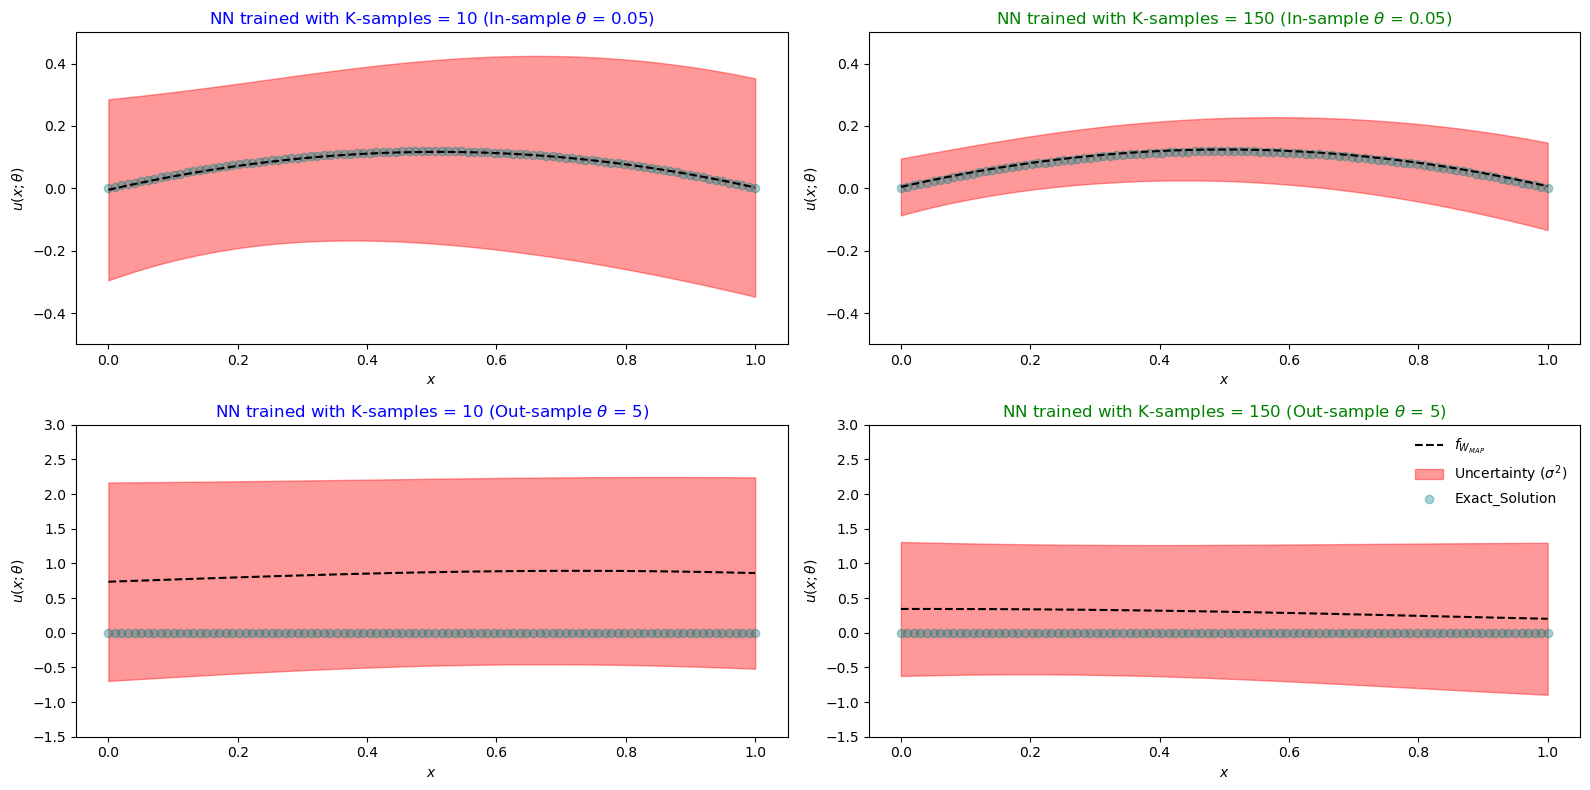

In [133]:
param_trained =  np.array([0.05,5])

prior_pre=torch.tensor([1])

prior_pre_diag_ = prior_precision_diag(prior_pre,nparam_2)

# Plotting
fig, axs = plt.subplots(len(param_trained), 2, figsize=(16, 8))

for n,pr in enumerate(param_trained):

    t, noise_sol_test = test_set(1,100,pr,mean,0)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))

    ######################################################################################

    forw_activation2 = {}
    h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_0'))

    f  = model2(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation2['layers.activation_0']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull2 + torch.diag(prior_pre_diag_)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)

    axs[0,1].set_title(r"NN trained with K-samples = 150 (In-sample $\theta$ = 0.05)",color="green")
    axs[1,1].set_title(r"NN trained with K-samples = 150 (Out-sample $\theta$ = 5)",color="green")

    axs[n,1].plot(t, f_mu, "--",color="black",label = r'$f_{W_{MAP}}$')
    axs[n,1].fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.4, color = "red",label = r"Uncertainty ($\sigma^{2}$)")
    axs[n,1].scatter(t,noise_sol_test, label = "Exact_Solution",color= "teal",alpha = 0.35)

    axs[n,1].set_xlabel("$x$")
    axs[n,1].set_ylabel("$u(x;\\theta)$")
    #plt.legend(frameon=False)
    #plt.tight_layout()

    ######################################################################################

    forw_activation = {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_0'))

    f  = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation['layers.activation_0']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag_)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)
    
    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)

    #######################################################################################

    axs[0,0].set_title(r"NN trained with K-samples = 10 (In-sample $\theta$ = 0.05)",color="blue")
    axs[1,0].set_title(r"NN trained with K-samples = 10 (Out-sample $\theta$ = 5)",color="blue")

    axs[n,0].plot(t, f_mu, "--",color="black",label = r'$f_{W_{MAP}}$')
    axs[n,0].fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.4, color = "red",label = r"Uncertainty ($\sigma^{2}$)")
    axs[n,0].scatter(t,noise_sol_test, label = "Exact_Solution",color= "teal",alpha = 0.35)

    axs[n,0].set_xlabel("$x$")
    axs[n,0].set_ylabel("$u(x;\\theta)$")
    
    if n== 0:
        axs[n,0].set_ylim([-0.5,0.5])
        axs[n,1].set_ylim([-0.5,0.5])
    else:

        axs[n,1].set_ylim([-1.5,3])
        axs[n,0].set_ylim([-1.5,3])


plt.legend(frameon=False)
plt.tight_layout()

plt.show()